In [29]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [30]:
# Load the data from the CSV file
df = pd.read_csv("../datasets/kangaroo-cleaned-for-analysis.csv")

# Display the first few rows to verify the data was loaded correctly
df.head(5)

,type,subtype,bedroomCount,bathroomCount,province,locality,postCode,habitableSurface,hasBasement,hasDressingRoom,...,hasVisiophone,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,price,epc_kwh,avg_price_per_postal_code
0,APARTMENT,APARTMENT,2.0,1.0,BRUSSELS,ETTERBEEK,1040,100.0,1,0,...,1,0,1.0,0,0,1,7.0,399000.0,175.0,415470.0
1,APARTMENT,APARTMENT,2.0,1.0,BRUSSELS,ETTERBEEK,1040,87.0,0,0,...,0,0,1.0,0,0,1,2.0,465000.0,425.0,415470.0
2,APARTMENT,APARTMENT,2.0,2.0,BRUSSELS,BRUXELLES,1040,104.0,0,0,...,1,0,2.0,0,0,1,3.0,590000.0,125.0,415470.0
3,APARTMENT,FLAT_STUDIO,1.0,1.0,BRUSSELS,ETTERBEEK,1040,71.0,0,0,...,0,0,1.0,0,0,0,0.0,289000.0,325.0,415470.0
4,APARTMENT,APARTMENT,2.0,1.0,BRUSSELS,ETTERBEEK,1040,90.0,1,0,...,0,0,1.0,0,0,1,2.0,375000.0,225.0,415470.0


### Calculate important metrics first

In [31]:
# Calculate average price per m²
df['price_per_m2'] = df['price'] / df['habitableSurface']

# Calculate average epc per m²  (JE me suis trompé, j'aurai dû multiplier et pas diviser)
df['epc_kwh_per_m2'] = df['epc_kwh'] * df['habitableSurface']#df['epc_kwh'] / df['habitableSurface']

## Price related plots
---


### Price per type of property with outliers



!['Price per type plot'](./price-per-type.png)

### Price Distribution

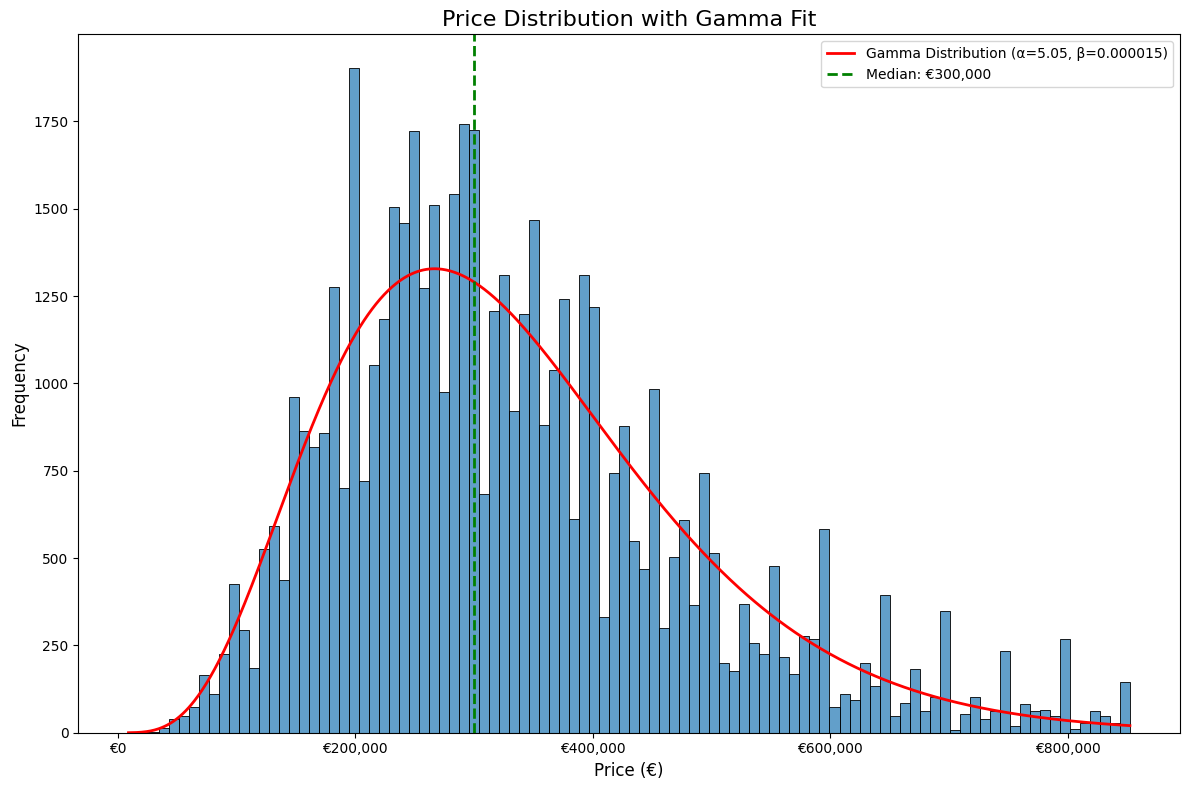

In [32]:
# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create the histogram
sns.histplot(df['price'], bins=100, kde=False, alpha=0.7)

# Fit gamma distribution to the data
price_data = df['price'].values
shape, loc, scale = stats.gamma.fit(price_data, floc=0)

# Calculate min and max for the x range
min_price = price_data.min()
max_price = price_data.max()

# Generate x values for the fitted distribution line
x = np.linspace(min_price, max_price, 1000)
# Generate pdf values for the gamma distribution
pdf = stats.gamma.pdf(x, shape, loc, scale)
# Scale pdf to match the histogram height
pdf_scaled = pdf * len(price_data) * (max_price - min_price) / 100

# Plot the gamma distribution line
plt.plot(x, pdf_scaled, 'r-', linewidth=2, label=f'Gamma Distribution (α={shape:.2f}, β={1/scale:.6f})')

# Calculate mean and median
# mean_price = df['price'].mean()
median_price = df['price'].median()

# Add vertical lines for mean and median
# plt.axvline(mean_price, color='green', linestyle='dashed', linewidth=2, label=f'Mean: €{mean_price:,.0f}')
plt.axvline(median_price, color='green', linestyle='dashed', linewidth=2, label=f'Median: €{median_price:,.0f}')

# Add labels and title
plt.title('Price Distribution with Gamma Fit', fontsize=16)
plt.xlabel('Price (€)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Format x-axis to show prices in a more readable format
plt.ticklabel_format(style='plain', axis='x')

# Format the x-axis with comma separators for thousands
def price_formatter(x, pos):
    return f'€{x:,.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.tight_layout()

# Show the plot
plt.show()

---

## Scatter Plots

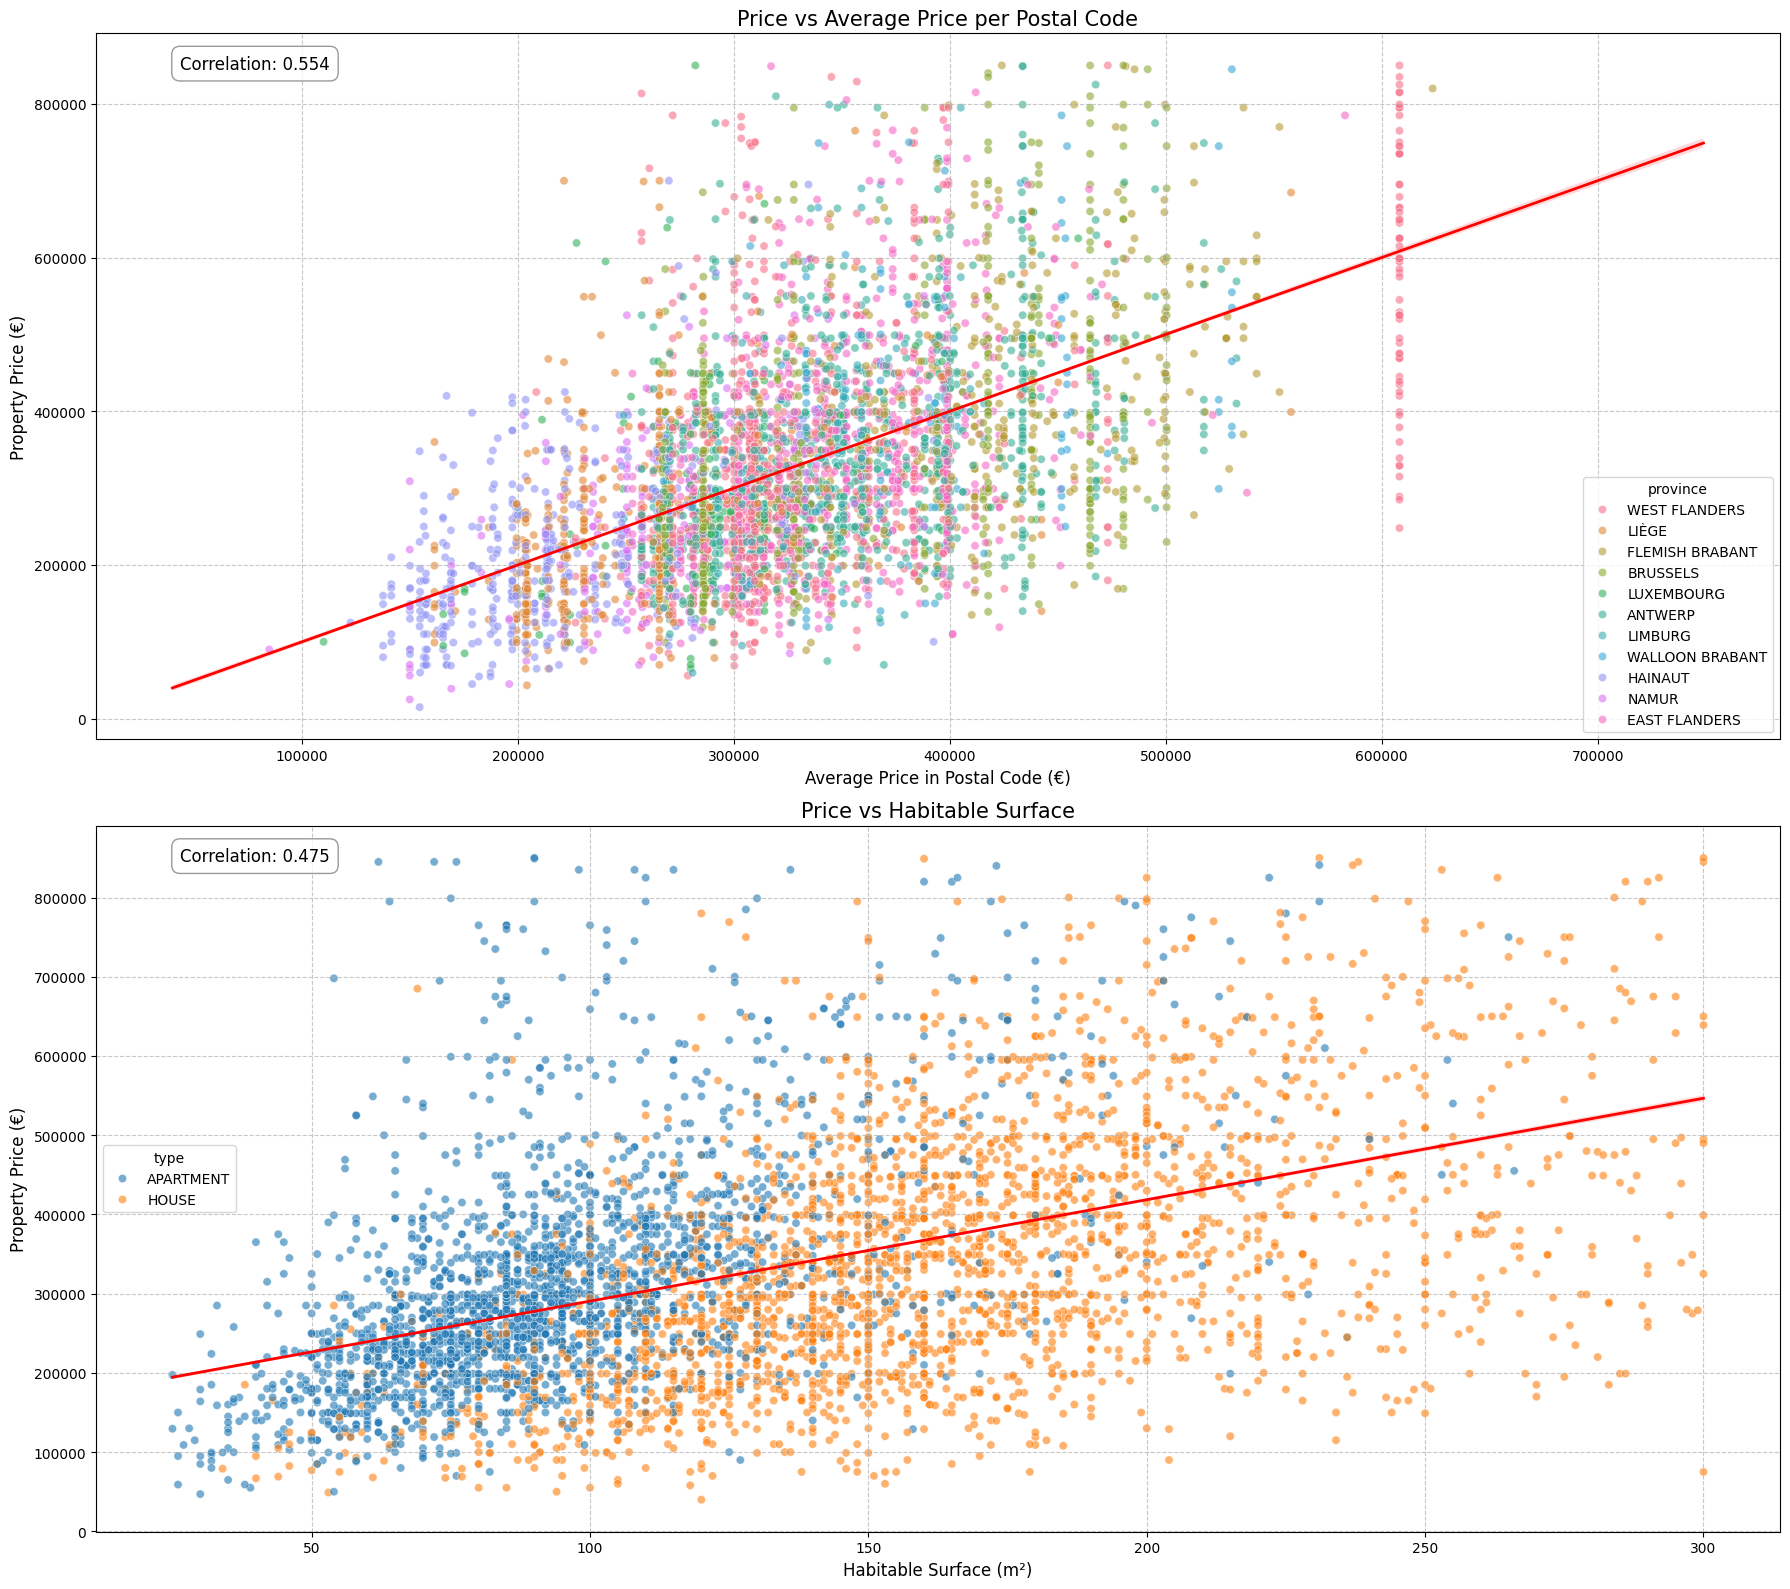

In [33]:
# Create a figure with subplots for the top correlations
fig, axs = plt.subplots(2, 1, figsize=(18, 16))

# 1. Price vs avg_price_per_postal_code (strongest correlation)
sns.scatterplot(
    x='avg_price_per_postal_code', 
    y='price',
    hue='province',
    alpha=0.6,
    data=df.sample(5000),
    ax=axs[0]
)

# Add regression line to the first plot
sns.regplot(
    x='avg_price_per_postal_code', 
    y='price', 
    data=df,
    scatter=False,
    color='red',
    line_kws={'linewidth': 2},
    ax=axs[0]
)

axs[0].set_title('Price vs Average Price per Postal Code', fontsize=15)
axs[0].set_xlabel('Average Price in Postal Code (€)', fontsize=12)
axs[0].set_ylabel('Property Price (€)', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Add correlation coefficient
corr = df['price'].corr(df['avg_price_per_postal_code'])
axs[0].annotate(f'Correlation: {corr:.3f}', 
               xy=(0.05, 0.95), xycoords='axes fraction',
               bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
               fontsize=12)

# 2. Price vs habitableSurface (second strongest correlation)
sns.scatterplot(
    x='habitableSurface', 
    y='price',
    hue='type',
    alpha=0.6,
    data=df.sample(5000),
    ax=axs[1]
)

# Add regression line to the second plot
sns.regplot(
    x='habitableSurface', 
    y='price', 
    data=df,
    scatter=False,
    color='red',
    line_kws={'linewidth': 2},
    ax=axs[1]
)

axs[1].set_title('Price vs Habitable Surface', fontsize=15)
axs[1].set_xlabel('Habitable Surface (m²)', fontsize=12)
axs[1].set_ylabel('Property Price (€)', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Add correlation coefficient
corr = df['price'].corr(df['habitableSurface'])
axs[1].annotate(f'Correlation: {corr:.3f}', 
               xy=(0.05, 0.95), xycoords='axes fraction',
               bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
               fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()

## Price x EPC Score x FacadeCount

C:\Users\ImJus\AppData\Local\Temp\ipykernel_28824\1145804563.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['facedeCount', 'epc_category'])['price'].mean().reset_index()


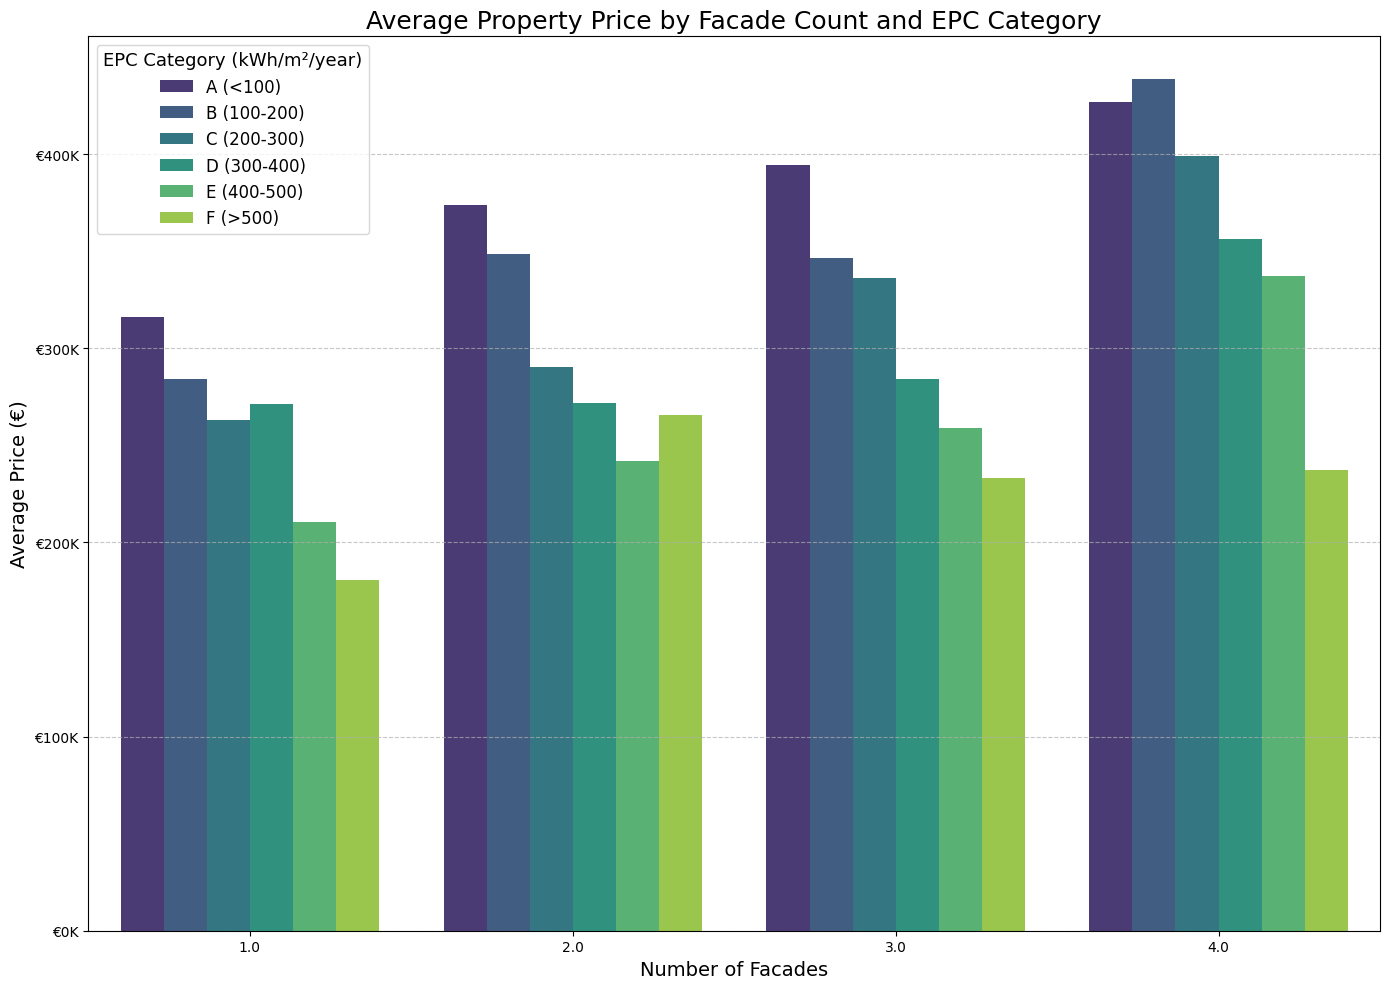

In [34]:
# Create a figure with a single plot
plt.figure(figsize=(14, 10))

# Create EPC categories
df['epc_category'] = pd.cut(
    df['epc_kwh'], 
    bins=[0, 100, 200, 300, 400, 500, float('inf')],
    labels=['A (<100)', 'B (100-200)', 'C (200-300)', 'D (300-400)', 'E (400-500)', 'F (>500)']
)

# Group by facade count and EPC category
grouped_data = df.groupby(['facedeCount', 'epc_category'])['price'].mean().reset_index()
grouped_data = grouped_data[grouped_data['facedeCount'] <= 4]

# Create a grouped bar chart
barplot = sns.barplot(
    x='facedeCount', 
    y='price', 
    hue='epc_category',
    palette='viridis',
    data=grouped_data
)

# Customize plot
plt.title('Average Property Price by Facade Count and EPC Category', fontsize=18)
plt.xlabel('Number of Facades', fontsize=14)
plt.ylabel('Average Price (€)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.legend(title='EPC Category (kWh/m²/year)', fontsize=12, title_fontsize=13)

# Format y-axis to show prices more clearly
def price_formatter(x, pos):
    if x >= 1000000:
        return f'€{x/1000000:.1f}M'
    else:
        return f'€{x/1000:.0f}K'

plt.gca().yaxis.set_major_formatter(FuncFormatter(price_formatter))

# Add value labels on top of the bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='', label_type='edge', fontsize=9, 
                      padding=2, rotation=90)

plt.tight_layout()
plt.show()


## M² Habitable Surface x Number of Facades

C:\Users\ImJus\AppData\Local\Temp\ipykernel_28824\3599019904.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


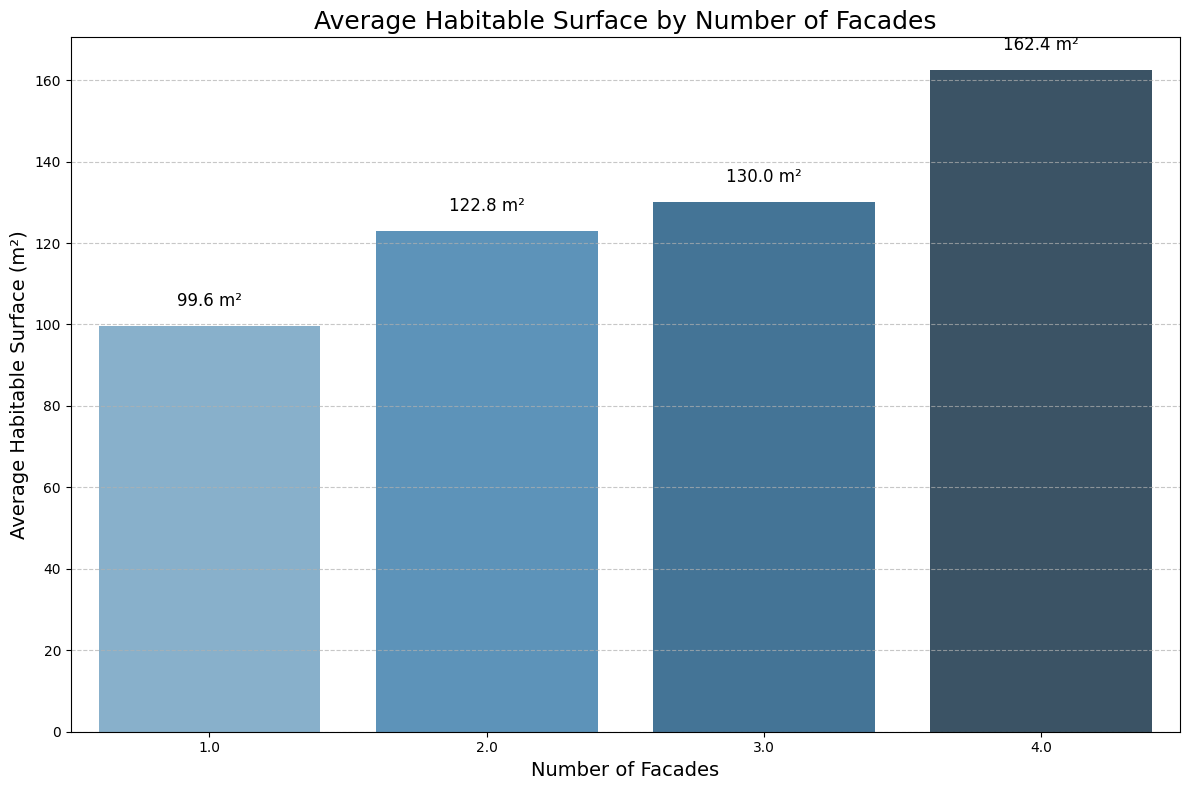

In [35]:
# Group by facade count
facade_surface = df.groupby('facedeCount')['habitableSurface'].mean().reset_index()
facade_surface = facade_surface[facade_surface['facedeCount'] <= 4]

# Create the plot
plt.figure(figsize=(12, 8))

# Create bar chart
ax = sns.barplot(
    x='facedeCount',
    y='habitableSurface',
    data=facade_surface,
    palette='Blues_d',
)

# Add data labels on top of bars
for i, v in enumerate(facade_surface['habitableSurface']):
    ax.text(i, v + 5, f'{v:.1f} m²', ha='center', fontsize=12)

# Customize plot
plt.title('Average Habitable Surface by Number of Facades', fontsize=18)
plt.xlabel('Number of Facades', fontsize=14)
plt.ylabel('Average Habitable Surface (m²)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.show()

## EPC Score x Number Facades

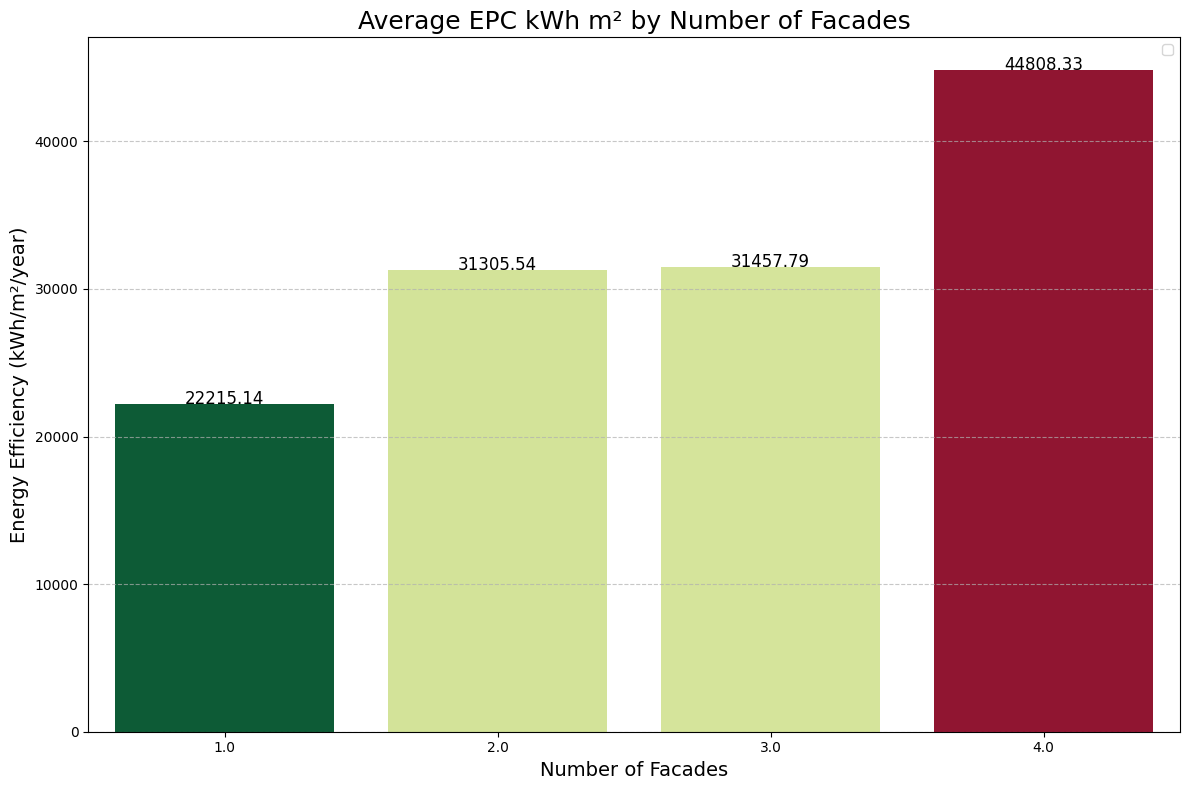

In [36]:
# Group by facade count
facade_kwh = df.groupby('facedeCount')['epc_kwh_per_m2'].mean().reset_index()
facade_kwh = facade_kwh[facade_kwh['facedeCount'] <= 4]

# Create the plot
plt.figure(figsize=(12, 8))

# Create bar chart
ax = sns.barplot(
    x='facedeCount',
    y='epc_kwh_per_m2',
    data=facade_kwh,
    palette='RdYlGn_r',
    hue='epc_kwh_per_m2',
)

# Add data labels on top of bars
for i, v in enumerate(facade_kwh['epc_kwh_per_m2']):
    ax.text(i, v + 0.03, f'{v:.2f}', ha='center', fontsize=12)

# Customize plot
plt.title('Average EPC kWh m² by Number of Facades', fontsize=18)
plt.xlabel('Number of Facades', fontsize=14)
plt.ylabel('Energy Efficiency (kWh/m²/year)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.legend('')
plt.show()

---

## Average price per locations

### Average price per province

!['Average Price per province'](./avg-price-per-province.png)

### Average Price per m² by Province

Skipping field reg_code: unsupported OGR type: 5
Skipping field prov_code: unsupported OGR type: 5
Skipping field prov_name_fr: unsupported OGR type: 5
Skipping field prov_name_nl: unsupported OGR type: 5
Skipping field prov_name_de: unsupported OGR type: 5
Skipping field reg_name_de: unsupported OGR type: 5
Skipping field reg_name_nl: unsupported OGR type: 5
Skipping field reg_name_fr: unsupported OGR type: 5


<Figure size 1200x1000 with 0 Axes>

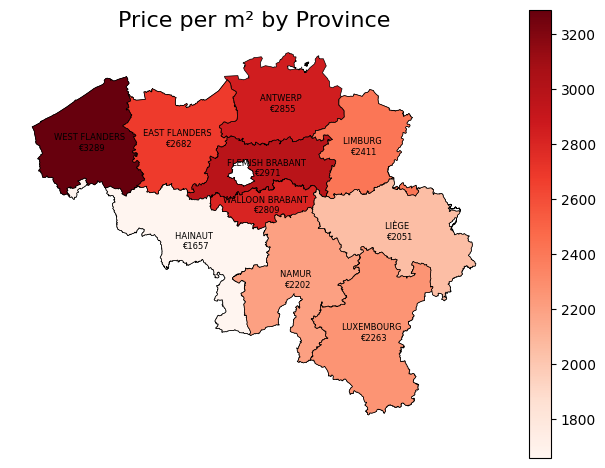

In [37]:
import geopandas as gpd

import matplotlib.pyplot as plt

postcode_price = df.groupby('province')['price_per_m2'].mean().reset_index()

plt.figure(figsize=(12, 10))

# Try to get Belgium shapefile
try:
    # Load Belgium provinces shapefile
    belgium = gpd.read_file('../datasets/georef-belgium-province.geojson')
    
    # Standardize province names to match our data
    province_map = {
        'Brussels-Capital': 'BRUSSELS',
        'PROVINCE D’ANVERS': 'ANTWERP',
        'PROVINCE DU BRABANT FLAMAND': 'FLEMISH BRABANT',
        'PROVINCE DE FLANDRE ORIENTALE': 'EAST FLANDERS',
        'PROVINCE DE FLANDRE OCCIDENTALE': 'WEST FLANDERS',
        'PROVINCE DU LIMBOURG': 'LIMBURG',
        'PROVINCE DU BRABANT WALLON': 'WALLOON BRABANT',
        'PROVINCE DU HAINAUT': 'HAINAUT',
        'PROVINCE DE LIÈGE': 'LIÈGE',
        'PROVINCE DU LUXEMBOURG': 'LUXEMBOURG',
        'PROVINCE DE NAMUR': 'NAMUR'
    }
    
    belgium['province_std'] = belgium['prov_name_upper_fr'].map(province_map)
    
    # Merge with our price data
    belgium = belgium.merge(postcode_price, left_on='province_std', right_on='province', how='left')
    
    belgium.plot(column='price_per_m2', cmap='Reds', legend=True, edgecolor='black', linewidth=0.5)
    
    for idx, row in belgium[belgium['year'] == '2023'].iterrows():
        plt.annotate(text=f"{row['province_std']} \n€{int(row['price_per_m2'])}", 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y-0.05),
                    ha='center', fontsize=6)
    
    plt.title('Price per m² by Province', fontsize=16)
    plt.axis('off')
    
except Exception as e:
    # If shapefile loading fails, display error message
    plt.text(0.5, 0.5, f"Map could not be loaded.\nConsider installing geopandas and downloading Belgium shapefile.", 
             ha='center', va='center', fontsize=10)
    # plt.set_axis_off()
    print(f"Error loading map: {e}")

plt.tight_layout()
plt.show()

### Average price per m² by postal code


Skipping field reg_code: unsupported OGR type: 5
Skipping field prov_code: unsupported OGR type: 5
Skipping field prov_name_fr: unsupported OGR type: 5
Skipping field prov_name_nl: unsupported OGR type: 5
Skipping field prov_name_de: unsupported OGR type: 5
Skipping field reg_name_de: unsupported OGR type: 5
Skipping field reg_name_nl: unsupported OGR type: 5
Skipping field reg_name_fr: unsupported OGR type: 5


<Figure size 2000x1800 with 0 Axes>

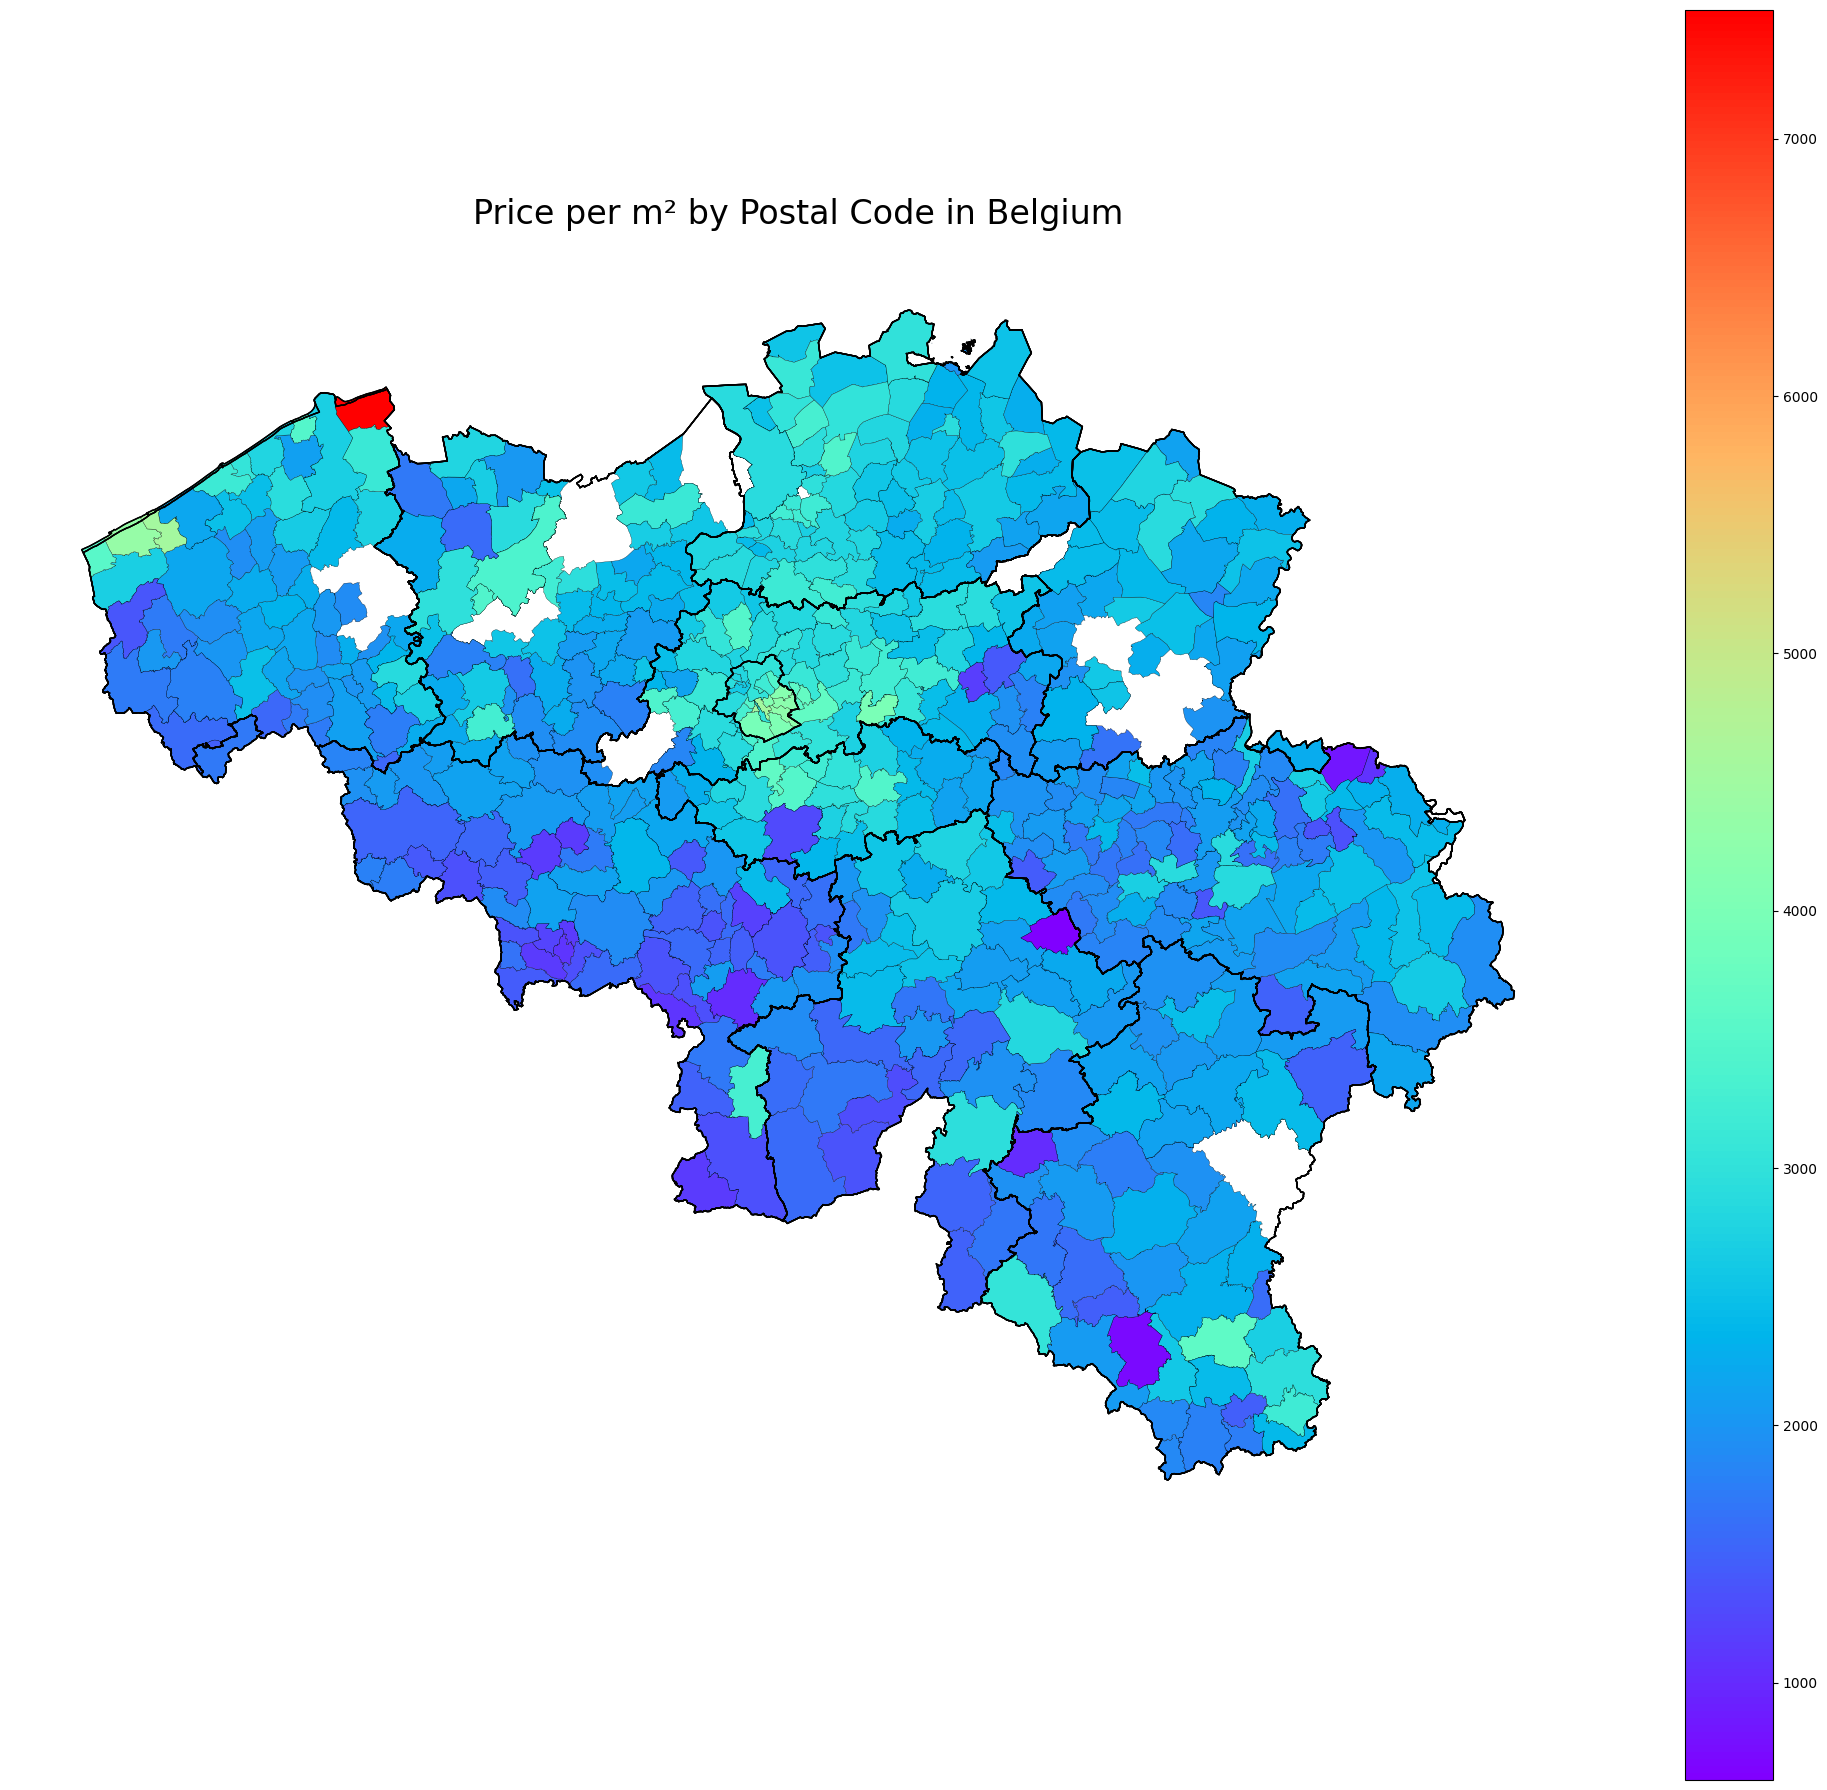

In [38]:
import geopandas as gpd


df.rename(columns={'postCode': 'postcode'}, inplace=True)
postcode_price = df.groupby('postcode')['price_per_m2'].mean().reset_index()

# Create a figure with a larger size
plt.figure(figsize=(20, 18))

# Try to get Belgium shapefile
try:
    # Load postal codes geodata
    belgium = gpd.read_file('../datasets/codes-ins-nis-postaux-belgique.geojson')
    belgium = belgium[['postal_code', 'geometry']]
    belgium['postcode'] = belgium['postal_code'].astype(int)
    belgium.drop(columns=['postal_code'], inplace=True)
    
    # Merge with price data
    belgium = belgium.merge(postcode_price, on='postcode')
    
    # Load province boundaries
    provinces = gpd.read_file('../datasets/georef-belgium-province.geojson')
    
    # Create the map
    ax = belgium.plot(column='price_per_m2', 
                      cmap='rainbow',
                      legend=True,
                      edgecolor='black',
                      linewidth=0.2,
                      figsize=(20, 18))
    
    # Add province boundaries with thicker lines and no fill
    provinces.boundary.plot(ax=ax, color='black', linewidth=1.0)
    
    # Remove axis completely
    ax.set_axis_off()
    
    # Add a title with larger font size
    plt.title('Price per m² by Postal Code in Belgium', fontsize=24, pad=20)
    
except Exception as e:
    # If shapefile loading fails, display error message
    plt.text(0.5, 0.5, f"Map could not be loaded.\nError: {e}", 
             ha='center', va='center', fontsize=12)
    print(f"Error loading map: {e}")

plt.tight_layout()
plt.show()

---

## Final Result Correlations


!['Final Correlations'](./final-correlation-result.png)